In [269]:
import warnings
warnings.filterwarnings('ignore')

In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

import pickle
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
# Load the data
file_path = Path('Movies.csv')
df = pd.read_csv(file_path)

## Clean up data 

In [272]:
# drop the column titled 'Type', 'Country' , 'Language', 'Rotten Tomatoes' 
df.drop (['ID','Type', 'Country', 'Language'], axis=1, inplace=True )

In [273]:
# drop the'Unnamed' column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Runtime
0,Inception,2010,13+,8.8,87%,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller",148.0
1,The Matrix,1999,18+,8.7,87%,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",136.0
2,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",149.0
3,Back to the Future,1985,7+,8.5,96%,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",116.0
4,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,Sergio Leone,Western,161.0


In [274]:
# Drop the null rows
df = df.dropna()

In [275]:
# Drop duplicate title
df.drop_duplicates(subset=['Title'],inplace=True)

## Understand further relationships

In [276]:
# See what we're working with
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3310 entries, 0 to 16705
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            3310 non-null   object 
 1   Year             3310 non-null   int64  
 2   Age              3310 non-null   object 
 3   IMDb             3310 non-null   float64
 4   Rotten Tomatoes  3310 non-null   object 
 5   Netflix          3310 non-null   int64  
 6   Hulu             3310 non-null   int64  
 7   Prime Video      3310 non-null   int64  
 8   Disney+          3310 non-null   int64  
 9   Directors        3310 non-null   object 
 10  Genres           3310 non-null   object 
 11  Runtime          3310 non-null   float64
dtypes: float64(2), int64(5), object(5)
memory usage: 336.2+ KB


In [277]:
import seaborn as sns

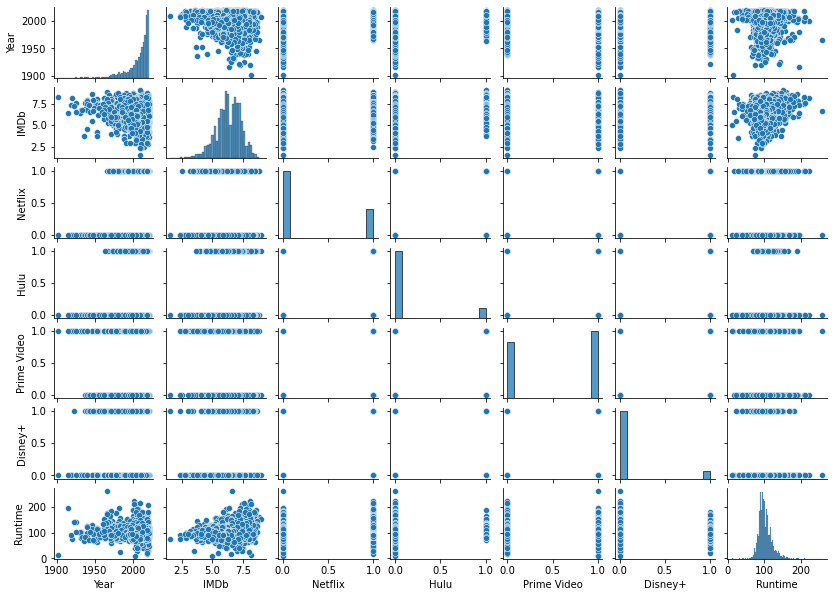

In [278]:
# Visualize some relationships
sns.pairplot(df, height=1.2, aspect=1.40)
plt.savefig('pariplot.png');

In [280]:
df.set_index('Title',inplace=True)
# Reset the index to be the Title

## Runtime

In [281]:
#Test out basic component of the new DataFrame.
#Target: IMDb Rating
X, y = df[['Runtime']], df['IMDb']


In [282]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0725


## Age Group

In [283]:
#Clean up age group
df['Age'] = df['Age'].str.replace('+', '')
df ['Age'] = df ['Age'].str.replace ('all', '7')

In [284]:
X, y = df[['Age']], df['IMDb']

In [285]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0127


## Rotten Tomatoes

In [286]:
# Get dummy variables for RT ratings
rt_df = pd.get_dummies(df['Rotten Tomatoes'])

In [287]:
# Add them to the rest of the data
df_added_rt_dummies = pd.concat([df,rt_df], axis=1)

In [288]:
# Let's add the RT dummy variables to our model
X, y = df_added_rt_dummies[['Runtime',]], df_added_rt_dummies['IMDb']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0725


## Years since release

In [289]:
df['Years since release'] = (2020 - df['Year'])

In [290]:
year_df = pd.get_dummies(df['Years since release'])

In [291]:
# Add them to the rest of the data
df_added_year_dummies = pd.concat([df,year_df], axis=1)

In [292]:
# Let's add the dummy variables to our model
X, y = df_added_year_dummies[['Years since release',]], df_added_year_dummies['IMDb']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0129


## Genre

In [293]:
# Turns genres into dummy variables
df_genres_added = pd.Series(df_added_rt_dummies['Genres'])
df_genres_added = pd.get_dummies(df_genres_added.apply(pd.Series).stack()).sum(level=0)

In [294]:
df_genres_rt = pd.concat([df_added_rt_dummies, df_genres_added], axis=1)

In [295]:
X, y = df_genres_rt[['Runtime','Action','Comedy','Crime','Drama','Horror','Musical','Romance','Sci-Fi','Sport','Thriller','War','Western']], df_genres_rt['IMDb']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0895


## Director

In [296]:
# Now I'd like to try and sort out Director for some more intricate measures of success
# check if there are any missing director information
df[df['Directors']==''].index.tolist()

[]

In [297]:
def directors_list(directors):
    if "," in directors:
        return [name.strip() for name in directors.split(",")]
    else:
        return [directors]

In [298]:
df['Directors'] = df['Directors'].apply(lambda x: directors_list(x))
# Turns directors into a list to fix some inconsistencies

In [299]:
def remove_paren(directors):
    dir_list = []
    for director in directors:
        if "(" in director:
            dir_clean = director.split("(")[0].strip()
            dir_list.append(dir_clean)
        else:
            dir_list.append(director)
    return dir_list

In [300]:
df['Directors'] = df['Directors'].apply(lambda x: remove_paren(x))
# Remove parentheses in director columns

In [301]:
# Create a function to select top directors and create new columns
# This will let us create dummy variables just for top directors
def top_directors(directors):
    dir_list = []
    for director in directors:
        if director in dir_10:
            dir_list.append(director)
    return dir_list

In [302]:
# Explode out directors to report on their relevance
df_dir_exploded = df.explode('Directors')

In [303]:
dir_10 = df_dir_exploded['Directors'].value_counts()[:10].index.tolist()
dir_10

['Robert Stevenson',
 'Kenny Ortega',
 'Jay Roach',
 'Steven Spielberg',
 'Steven Brill',
 'Quentin Tarantino',
 'Robert Zemeckis',
 'Robert Altman',
 'Tyler Perry',
 'Bradley Raymond']

In [304]:
# Apply that function to create a new column
df['Top directors'] = df['Directors'].apply(lambda x: top_directors(x))
df

,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Runtime,Years since release,Top directors
Title,,,,,,,,,,,,,
Inception,2010,13,8.8,87%,1,0,0,0,[Christopher Nolan],"Action,Adventure,Sci-Fi,Thriller",148.0,10,[]
The Matrix,1999,18,8.7,87%,1,0,0,0,"[Lana Wachowski, Lilly Wachowski]","Action,Sci-Fi",136.0,21,[]
Avengers: Infinity War,2018,13,8.5,84%,1,0,0,0,"[Anthony Russo, Joe Russo]","Action,Adventure,Sci-Fi",149.0,2,[]
Back to the Future,1985,7,8.5,96%,1,0,0,0,[Robert Zemeckis],"Adventure,Comedy,Sci-Fi",116.0,35,[Robert Zemeckis]
"The Good, the Bad and the Ugly",1966,18,8.8,97%,1,0,1,0,[Sergio Leone],Western,161.0,54,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Kid in King Arthur's Court,1995,7,4.7,5%,0,0,0,1,[Michael Gottlieb],"Adventure,Comedy,Family,Fantasy,Romance",89.0,25,[]
George of the Jungle 2,2003,7,3.3,17%,0,0,0,1,[David Grossman],"Adventure,Comedy,Family",87.0,17,[]
That Darn Cat,1997,7,4.7,13%,0,0,0,1,[Robert Stevenson],"Comedy,Crime,Family,Thriller",116.0,23,[Robert Stevenson]


In [305]:
dir_df = pd.get_dummies(df['Top directors'].apply(pd.Series).stack()).sum(level=0)

In [306]:
df_dir_model = pd.concat([df_genres_rt, dir_df], axis=1)
# Merge dummies with model DataFrame

In [307]:
df_dir_model.drop(labels=['Genres','Directors', 'Age', 'Rotten Tomatoes'],axis=1,inplace=True)
# Let's take out the columns we're not using

In [308]:
df_dir_model.replace(np.nan,0,inplace=True)
# Replace all of the NaN values with 0s to turn it into a proper binary dataset

In [309]:
X, y = df_dir_model.iloc[:,2:], df_dir_model['IMDb']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))
# So we moved up 0.02 points again, which isn't nothing. Let's try the same concept for writers

R-squared: 0.6789


## Train / Validation / Test

In [310]:
X, y = df_added_year_dummies[['Years since release',]], df_added_year_dummies['IMDb']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [311]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=20)

In [312]:
# Let's first test Linear Regression vs Polynomial Features
lr = LinearRegression()

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lr_poly = LinearRegression()

In [313]:
lr.fit(X_train, y_train)
print(f'Linear Regression val R-squared: {lr.score(X_val, y_val):.3f}')

lr_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R-squared: {lr_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R-squared: 0.011
Degree 2 polynomial regression val R-squared: 0.013


In [314]:
X, y = df_added_year_dummies[['Years since release',]], df_added_year_dummies['IMDb']
# Reset the data for the next model

In [315]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y) 
lr = LinearRegression()

In [316]:
# Here we'll validate our Linear model vs. the Ridge model
kf = KFold(n_splits=5, shuffle=True, random_state = 61)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #Linear Regression
    lr = LinearRegression()
    lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
    #Ridge
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr_reg.fit(X_train_scaled, y_train)
    cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lr_r2s)
print('Ridge scores: ', cv_lr_reg_r2s, '\n')

print(f'Simple mean cv R-squared: {np.mean(cv_lr_r2s):.3f} +- {np.std(cv_lr_r2s):.3f}')
print(f'Ridge mean cv R-squared: {np.mean(cv_lr_reg_r2s):.3f} +- {np.std(cv_lr_reg_r2s):.3f}')

Simple regression scores:  [0.007296981404570024, 0.02536524204587598, 0.026494289847297292, 0.00801116293633164, -0.0014771006106242268]
Ridge scores:  [0.007300933737299453, 0.02535775258499917, 0.026487464503984537, 0.008017798000475529, -0.0014677867032084624] 

Simple mean cv R-squared: 0.013 +- 0.011
Ridge mean cv R-squared: 0.013 +- 0.011


In [317]:
X, y = df_added_year_dummies[['Years since release',]], df_added_year_dummies['IMDb']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
# Reset the data for the next model

In [318]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Rescale the data for more Ridge testing

In [319]:
lr_reg.fit(X_train_scaled, y_train);
# The code for our Ridge model

In [320]:
test_set_pred = lr_reg.predict(X_test_scaled)
# Set our predicted values to a variable

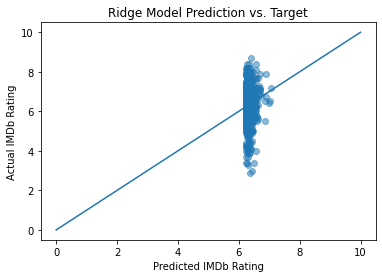

In [321]:
plt.scatter(test_set_pred, y_test, alpha=.5)
plt.plot(np.linspace(0,10), np.linspace(0,10))
plt.title('Ridge Model Prediction vs. Target')
plt.xlabel('Predicted IMDb Rating')
plt.ylabel('Actual IMDb Rating');
# The plot looks fairly decent

In [322]:
print('Ridge R-squared: {:.4f}'.format(r2_score(y_test, test_set_pred))) 
# Also, this r2 score doesn't look too bad either

Ridge R-squared: 0.0025


In [323]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print('MAE: {:.4f}'.format(mae(y_test, test_set_pred)))
# And the MAE isn't terrible either

MAE: 0.7498


In [324]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='green',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

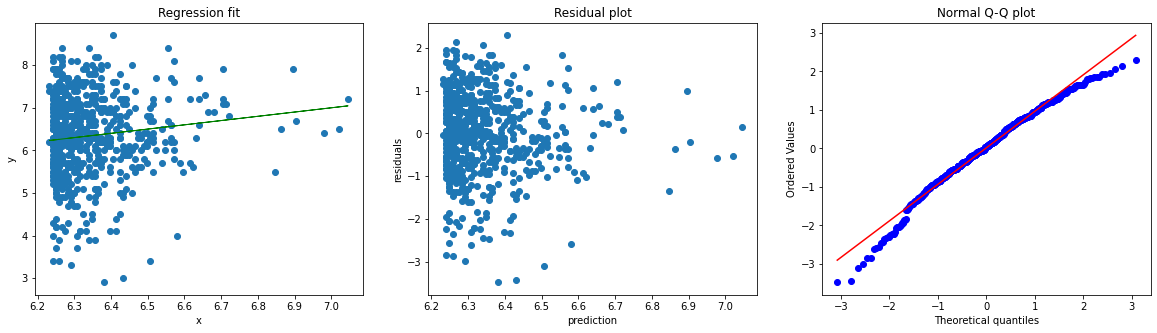

In [325]:
diagnostic_plot(test_set_pred, y_test)
# The head and tails of the Q-Q plot seem to tell a story about our data.
# Also, there seems to be an outlier than may be messing up our model, shown in the Regression fit.

In [326]:
X, y= df_added_year_dummies[['Years since release',]], df_added_year_dummies['IMDb']

In [327]:
X_scaled = scaler.fit_transform(X)
X_predicted = lr_reg.predict(X_scaled)
# Rescale the data for more Ridge testing

In [328]:
df_added_year_dummies['res'] = X_predicted - df_added_year_dummies['IMDb']
# Create a residuals column to determine if there is any relationship behind the movies that are overpredicted and underpredicted

In [329]:
df_added_year_dummies.sort_values(by='res',ascending=False, inplace=True)
df_added_year_dummies.head(10)
# The residual values are moving very slowly up to An Hour To Kill which has a large jump from BROS. Last Call.
# It seems like the bottom 5 are underpredicted

,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,...,88,89,90,95,98,100,101,105,118,res
Title,,,,,,,,,,,,,,,,,,,,,
Jonas Brothers: The Concert Experience,2009,7,1.6,24%,0,0,0,1,Bruce Hendricks,"Documentary,Music",...,0,0,0,0,0,0,0,0,0,4.725431
Hannah Montana & Miley Cyrus: Best of Both Worlds Concert,2008,7,2.4,73%,0,0,0,1,Bruce Hendricks,"Documentary,Music",...,0,0,0,0,0,0,0,0,0,3.933841
Mega Piranha,2010,18,2.4,8%,0,0,1,0,Eric Forsberg,"Action,Adventure,Comedy,Horror,Sci-Fi,Thriller",...,0,0,0,0,0,0,0,0,0,3.917021
Mega Shark vs. Giant Octopus,2009,18,2.5,18%,0,0,1,0,Jack Perez,"Action,Adventure,Comedy,Horror,Sci-Fi,Thriller",...,0,0,0,0,0,0,0,0,0,3.825431
Black Rose,2014,18,2.5,22%,1,0,0,0,Alexander Nevsky,"Action,Crime,Drama",...,0,0,0,0,0,0,0,0,0,3.783379
The Amityville Curse,1990,18,2.9,17%,0,0,1,0,Tom Berry,Horror,...,0,0,0,0,0,0,0,0,0,3.585229
Freestyle,2010,13,2.8,22%,0,0,1,0,Harley Cokeliss,Drama,...,0,0,0,0,0,0,0,0,0,3.517021
13th Child,2002,18,2.9,40%,0,0,1,0,"Thomas Ashley,Steven Stockage","Horror,Mystery,Thriller",...,0,0,0,0,0,0,0,0,0,3.484304
Shark Attack 3: Megalodon,2002,18,2.9,20%,0,0,1,0,David Worth,"Action,Adventure,Horror,Sci-Fi,Thriller",...,0,0,0,0,0,0,0,0,0,3.484304


In [330]:
underpredicted = df_added_year_dummies['res'].sort_values().head(5).index.tolist()
# Let's set those top 5 to a variable

In [331]:
df_added_year_dummies.sort_values(by='res',ascending=False, inplace=True)
df_added_year_dummies.tail(10)

# This side is fairly similar, the numbers move pretty slowly up 
# It looks like the top 10 are underprediected

,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,...,88,89,90,95,98,100,101,105,118,res
Title,,,,,,,,,,,,,,,,,,,,,
GoodFellas,1990,18,8.7,96%,0,1,0,0,Martin Scorsese,"Biography,Crime,Drama",...,0,0,0,0,0,0,0,0,0,-2.214771
Mahanati,2018,7,8.5,100%,0,0,1,0,Nag Ashwin,"Biography,Drama",...,0,0,0,0,0,0,0,0,0,-2.250263
Avengers: Infinity War,2018,13,8.5,84%,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",...,0,0,0,0,0,0,0,0,0,-2.250263
For Sama,2019,7,8.5,99%,0,0,1,0,"Waad Al-Kateab,Edward Watts","Documentary,War",...,0,0,0,0,0,0,0,0,0,-2.258673
Dave Chappelle: Sticks & Stones,2019,18,8.5,35%,1,0,0,0,Stan Lathan,Comedy,...,0,0,0,0,0,0,0,0,0,-2.258673
The Matrix,1999,18,8.7,87%,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",...,0,0,0,0,0,0,0,0,0,-2.290465
Parasite,2019,18,8.6,99%,0,1,1,0,Bong Joon Ho,"Comedy,Drama,Thriller",...,0,0,0,0,0,0,0,0,0,-2.358673
Hearing Is Believing,2017,7,8.7,60%,0,0,1,0,Lorenzo DeStefano,"Documentary,Biography,Family,Music",...,0,0,0,0,0,0,0,0,0,-2.441853
Inception,2010,13,8.8,87%,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller",...,0,0,0,0,0,0,0,0,0,-2.482979


In [332]:
overpredicted = df_added_year_dummies['res'].sort_values().tail(10).index.tolist()
# Let's set those to another variable


In [333]:
df.loc[underpredicted].index.tolist()

['The Dark Knight',
 'Inception',
 'Hearing Is Believing',
 'Parasite',
 'The Matrix']

In [334]:
df.loc[overpredicted].index.tolist()

['BloodRayne',
 'Shark Attack 3: Megalodon',
 '13th Child',
 'Freestyle',
 'The Amityville Curse',
 'Black Rose',
 'Mega Shark vs. Giant Octopus',
 'Mega Piranha',
 'Hannah Montana & Miley Cyrus: Best of Both Worlds Concert',
 'Jonas Brothers: The Concert Experience']